# Ejercico Redes Convolucionales con Pytorch

Clasificación de imágenes



In [11]:
# Inicialización
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [12]:
# Definición de constantes 
import os

# esto es para que funcione matplotlib 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 64
EPOCHS = 30
IMAGE_SIZE = 512
DATASET_DIR = 'data/DatasetTumoresCerebrales/'
MODELS_DIR = 'models/'


## Dataset

Como se puede observar en el dataset existe un desbalance en las clases tanto en train como en test.

Para solucionar esto aplicaremos oversampling:
- Aumentaremos el peso de las clases donde haya menos imágenes.
- Aplicaremos DataAugmentation.


In [13]:
# Cargamos dataset
from torchvision import datasets
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, RandomRotation, Grayscale
import torch.utils.data as data

#Aumento de datos
transforms = Compose(
    [
        Grayscale(),
        RandomRotation(30),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor()
    ]
)

train_data = datasets.ImageFolder(DATASET_DIR+'training',transform= transforms)
train, validation = data.random_split(train_data, [0.8, 0.2])
testing = datasets.ImageFolder(DATASET_DIR+'test', transform= transforms)

#Dado los datos que tenemos del dataset y el desbalance creamos el siguiente sampler
sampler = data.WeightedRandomSampler([1/1283, 1/637, 1/837], len(train_data), replacement = True)

In [14]:
train_data[0][0].shape

torch.Size([1, 512, 512])

In [15]:
train_dataloader = data.DataLoader(train, batch_size=BATCH_SIZE, sampler= sampler)
val_dataloader = data.DataLoader(validation, batch_size=BATCH_SIZE, sampler= sampler)
test_dataloader = data.DataLoader(testing, batch_size=BATCH_SIZE, sampler= sampler)

## Elección de Arquitectura

### Red Convolucional

In [16]:
from torch import nn
from torchinfo import summary

#Bloque convolucional normalizado
def bloque_conv_norm(in_features, out_features):
    return nn.Sequential(
            nn.Conv2d(in_features, out_features, 4, 1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = bloque_conv_norm(1, 32)
        self.conv2 = bloque_conv_norm(32, 64)
        self.conv3 = bloque_conv_norm(64, 64)
        self.linear_out = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(238144, 3)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        logits = self.linear_out(x)
        return logits


In [17]:
# creamos el modelo
torch.cuda.empty_cache()
model = ConvNet() #ConvNet1 #ConvNet2
model.to(device)

summary(model,
        input_size=(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ConvNet (ConvNet)                        [64, 1, 512, 512]    [64, 3]              --                   True
├─Sequential (conv1)                     [64, 1, 512, 512]    [64, 32, 254, 254]   --                   True
│    └─Conv2d (0)                        [64, 1, 512, 512]    [64, 32, 509, 509]   544                  True
│    └─BatchNorm2d (1)                   [64, 32, 509, 509]   [64, 32, 509, 509]   64                   True
│    └─ReLU (2)                          [64, 32, 509, 509]   [64, 32, 509, 509]   --                   --
│    └─MaxPool2d (3)                     [64, 32, 509, 509]   [64, 32, 254, 254]   --                   --
├─Sequential (conv2)                     [64, 32, 254, 254]   [64, 64, 125, 125]   --                   True
│    └─Conv2d (0)                        [64, 32, 254, 254]   [64, 64, 251, 251]   32,832               True
│    └─BatchNorm2d

In [18]:

# función de entrenamiento
def train(dataloader, model, loss_fn, optimizer, losses, accuracy):
    size = len(dataloader.dataset)

    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            train_acc = 100*correct / size
            losses.append(loss.item())
            print(f"Accuracy: {train_acc:>0.1f}%, Avg loss: {loss.item():>8f} [{current:>5d}/{size:>5d}]")

    train_acc = 100*correct/size
    accuracy.append(train_acc)

def validate(dataloader, model, loss_fn, losses, accuracy):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    val_acc = 100 * correct / size
    losses.append(val_loss)
    accuracy.append(val_acc)
    print(f"Validation: Accuracy: {val_acc:>0.1f}%, Avg loss: {val_acc:>8f} \n")

# función de test
def test(dataloader, model, loss_fn, losses, accuracy):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_acc = 100*correct/size
    losses.append(test_loss)
    accuracy.append(test_acc)
    print(f"Test Error: \n Accuracy: {test_acc:>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [19]:
from torch import optim

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Number of epochs
EPOCHS = 5

# Lists to store training and validation results
train_loss = []
val_loss_list = []
test_loss = []
train_acc_list = []
val_acc_list = []
test_acc = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}/{EPOCHS}\n-------------------------------")
    
    # Training phase
    size = len(train_dataloader.dataset)

    model.train()
    correct = 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            train_acc = 100*correct / size
            train_loss.append(loss.item())
            print(f"Accuracy: {train_acc:>0.1f}%, Avg loss: {loss.item():>8f} [{current:>5d}/{size:>5d}]")

    train_acc = 100*correct/size
    
    train_acc_list.append(train_acc)

    # Validation phase
    size = len(val_dataloader.dataset)
    num_batches = len(val_dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    val_acc = 100 * correct / size
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f"Validation: Accuracy: {val_acc:>0.1f}%, Avg loss: {val_loss:>8f} \n")
    
    scheduler.step(val_loss)
    

print("Training and Validation Done!")

test(test_dataloader, model, loss_fn, test_loss, test_acc)
print("Test Done!")

# Save the trained model
torch.save(model.state_dict(), MODELS_DIR + "model_cnn.pth")
print("Model saved as model_cnn.pth")


Epoch 1/5
-------------------------------
Accuracy: 1.6%, Avg loss: 0.971739 [   64/ 2206]
Validation: Accuracy: 184.0%, Avg loss: 714.872550 

Epoch 2/5
-------------------------------
Accuracy: 2.9%, Avg loss: 0.000000 [   64/ 2206]
Validation: Accuracy: 110.7%, Avg loss: 625.700648 

Epoch 3/5
-------------------------------
Accuracy: 2.9%, Avg loss: 0.000000 [   64/ 2206]
Validation: Accuracy: 114.2%, Avg loss: 627.368396 

Epoch 4/5
-------------------------------
Accuracy: 2.9%, Avg loss: 0.000000 [   64/ 2206]
Validation: Accuracy: 114.0%, Avg loss: 623.724537 

Epoch 5/5
-------------------------------
Accuracy: 2.9%, Avg loss: 0.000000 [   64/ 2206]
Validation: Accuracy: 111.6%, Avg loss: 615.748575 

Training and Validation Done!
Test Error: 
 Accuracy: 502.9%, Avg loss: 821.571333 

Test Done!
Model saved as model_cnn.pth


ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

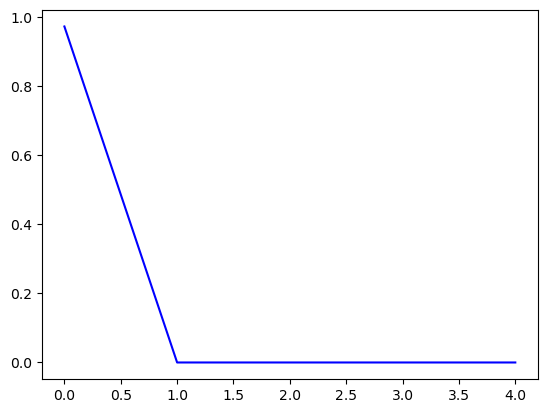

In [20]:
import matplotlib.pyplot as plt

def draw_graphics(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc):
    # Dibujamos las gráficas
    x = range(len(train_loss))
    
    plt.figure()
    plt.plot(x, train_loss, color='blue')
    plt.plot(x, val_loss, color='green')
    plt.plot(x, test_loss, color='red')
    plt.legend(['Train Loss', 'Validation Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('loss_plot.png')

    plt.figure()
    plt.plot(x, train_acc, color='blue')
    plt.plot(x, val_acc, color='green')
    plt.plot(x, test_acc, color='red')
    plt.legend(['Train Accuracy', 'Validation Accuracy', 'Test Accuracy'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('accuracy_plot.png')

draw_graphics(train_loss, val_loss_list, test_loss, train_acc_list, val_acc_list, test_acc)
train_loss = []
val_loss_list = []
test_loss = []
train_acc_list = []
val_acc_list = []
test_acc = []

# Transfer Learning: ResNet18 y EfficientNet_V2_S

## ResNet18

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Compose, Grayscale
import numpy as np

# Instanciamos el modelo ResNet18 con los pesos por defecto
weights=ResNet18_Weights.DEFAULT
auto_transforms = weights.transforms()

# Cargamos el dataset con las transformaciones originales
transform=Compose(
    [
        RandomRotation(30),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        auto_transforms,
    ]
    )

training = datasets.MNIST('data', train=True, download=True,
                          transform=transform)
testing = datasets.MNIST('data', train=False, download=True,
                      transform=transform)

# Seleccionamos un subconjunto de imágenes de entrenamiento 
reduced_training = Subset(training, range(2500))

train_dataloader = DataLoader(reduced_training, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(testing, batch_size=BATCH_SIZE)

# Estructura de los batches
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Creamos el modelo y congelamos parámetros de la red
model = resnet18(weights=weights).to(device)
for name, para in model.named_parameters():
    para.requires_grad = False

# Cambiamos la capa superior con una capa Lineal con 10 clases de salida
num_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features=num_features,
                    out_features=num_classes,
                    bias=True).to(device)

summary(model,
        input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)